## Setup

### Imports

In [3]:
import sys; sys.path.append('..')

In [4]:
# ! pip install lovely-tensors

import lovely_tensors as lt
lt.monkey_patch()

In [5]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig

In [6]:
import wandb
from tqdm.auto import tqdm

from omegaconf import OmegaConf

from datetime import datetime

from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from src.tree import list2tree
from src.tree_dataset import TreeDataset, parse_input_idx, input_tokens_to_tree, tree_to_edges
from src.utils import seed_all


from src.trainer import TreeTrainer

In [13]:
def load_model(device):
    n_states = 16
    max_seq_length = n_states * 4 + 2
    
    number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
    idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
    tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}
    
    
    cfg = HookedTransformerConfig(
        n_layers=6,
        d_model=128,
        n_ctx=max_seq_length - 1,
        n_heads=1,
        d_mlp=512,
        d_head=128,
        #attn_only=True,
        d_vocab=len(idx2tokens),
        device=device,
        attention_dir= "causal",
        act_fn="gelu",
    )
    model = HookedTransformer(cfg)
    
    model.load_state_dict(torch.load("/Users/mykhailokilianovskyi/src/backward-chaining-circuits/model.pt", map_location=torch.device(device)))
    
    return model

(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[14.907]], scores[q, k]=tensor grad SelectBackward0 14.907 k=0 q=1
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[-3.832]], scores[q, k]=tensor grad SelectBackward0 -3.832 k=0 q=2
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[-1.125]], scores[q, k]=tensor grad SelectBackward0 -1.125 k=1 q=2
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[-12.431]], scores[q, k]=tensor grad SelectBackward0 -12.431 k=0 q=3
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[1.276]], scores[q, k]=tensor grad SelectBackward0 1.276 k=1 q=3
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 [[18.058]], scores[q, k]=tensor grad SelectBackward0 18.058 k=2 q=3


Text(0.5, 0, 'Position Embedding in Key')

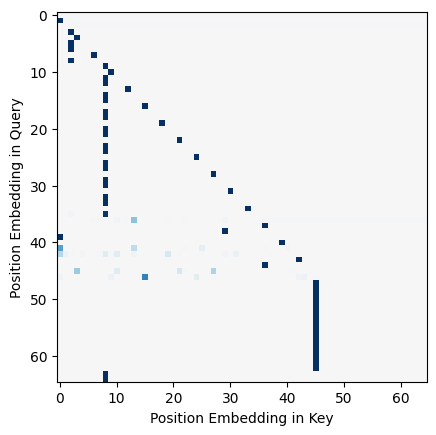

In [16]:
model = load_model('cpu')
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

            if q < 4:
                print(f'{(q_out @ k_out.T)=}, {scores[q, k]=} {k=} {q=}')


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[14.907]], scores[q, k]=tensor grad SelectBackward0 0. k=0 q=1
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[-3.832]], scores[q, k]=tensor grad SelectBackward0 0. k=0 q=2
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[-1.125]], scores[q, k]=tensor grad SelectBackward0 0. k=1 q=2
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[-12.431]], scores[q, k]=tensor grad SelectBackward0 0. k=0 q=3
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[1.276]], scores[q, k]=tensor grad SelectBackward0 0. k=1 q=3
(q_out @ k_out.T)=tensor[1, 1] grad MmBackward0 mps:0 [[18.058]], scores[q, k]=tensor grad SelectBackward0 0. k=2 q=3


Text(0.5, 0, 'Position Embedding in Key')

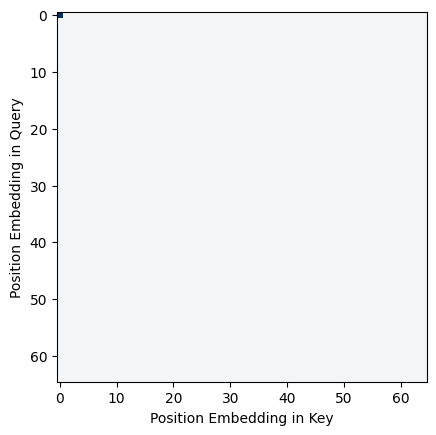

In [17]:
model = load_model('mps')
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

            if q < 4:
                print(f'{(q_out @ k_out.T)=}, {scores[q, k]=} {k=} {q=}')


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

In [239]:
scores = scores.detach().cpu().clone()
scores_np_mps0 = scores.detach().detach().clone().cpu().numpy()

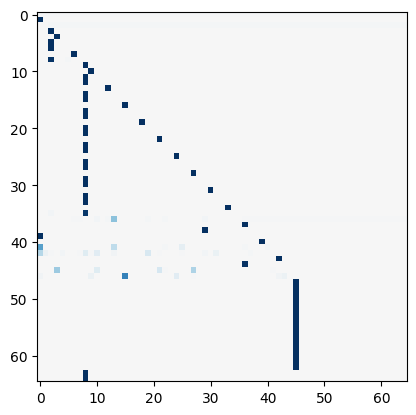

In [243]:
plt.imshow(scores.softmax(dim=1).detach().numpy(), cmap="RdBu", vmin=-1, vmax=1)

Text(0.5, 0, 'Position Embedding in Key')

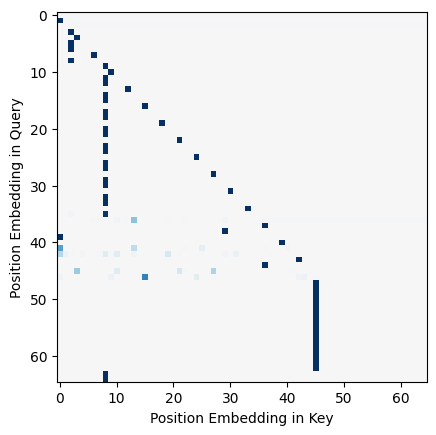

In [222]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

scores = scores.detach().cpu().clone()
scores_np_mps0 = scores.detach().detach().clone().cpu().numpy()
plt.imshow(scores.softmax(dim=1).detach().numpy(), cmap="RdBu", vmin=-1, vmax=1)
scores_np_mps1 = scores.detach().detach().cpu().numpy()

plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

In [223]:
scores

tensor[65, 65] n=4225 (17Kb) x∈[-56.219, 91.154] μ=-2.575 σ=12.256

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.906864  ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.831859  ,  -1.1249268 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-27.347038  ,   1.8288695 ,  12.538565  , ...,   0.        ,
          0.        ,   0.        ],
       [  3.8543057 ,   6.9255457 ,  20.011084  , ...,  -0.07043433,
          0.        ,   0.        ],
       [  0.9165263 ,   6.085339  ,  21.66562   , ...,  -2.7506723 ,
         13.901514  ,   0.        ]], dtype=float32)

In [190]:
scores_np_mps1

array([[13.901515,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [74]:
model.blocks[0].attn.W_Q[0].v

tensor[128, 128] n=16384 (64Kb) x∈[-0.280, 0.300] μ=-0.001 σ=0.073 grad SelectBackward0 mps:0
tensor([[-0.0655,  0.0709, -0.0205,  ...,  0.0554,  0.0823,  0.1564],
        [-0.0206,  0.1043, -0.0218,  ..., -0.0063,  0.0522, -0.0086],
        [ 0.0364, -0.0731, -0.0790,  ...,  0.0568,  0.0472, -0.0114],
        ...,
        [ 0.0154, -0.1034,  0.2008,  ..., -0.0355, -0.0214, -0.0540],
        [-0.0647, -0.0232,  0.1603,  ...,  0.0598, -0.0769,  0.0298],
        [-0.0760, -0.1239,  0.0162,  ...,  0.0463,  0.0340,  0.0130]],
       device='mps:0', grad_fn=<SelectBackward0>)

In [76]:
scores.softmax(dim=1).detach()[:3, :3].v

tensor[3, 3] n=9 x∈[9.175e-07, 1.000] μ=0.121 σ=0.330 [[1.000, 9.175e-07, 9.175e-07], [0.015, 0.015, 0.015], [0.015, 0.015, 0.015]]
tensor([[9.9994e-01, 9.1754e-07, 9.1754e-07],
        [1.5385e-02, 1.5385e-02, 1.5385e-02],
        [1.5385e-02, 1.5385e-02, 1.5385e-02]])